In [1]:
#Import Packages
##Import Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from scipy.signal import find_peaks

In [2]:
#Get Data
cols = ["frequency", "signal", "temp", "pressure", "excitation"]
raw_data1 = pd.read_csv("Data/Oxygen_Nitrogen_mixture_resonance.lvm", delimiter="\t", names=cols)
raw_data2 = pd.read_csv("Data/GROUP4_nitrogen_run3.lvm", delimiter="\t", names=cols)

raw_data1

,frequency,signal,temp,pressure,excitation
NaN,1800.0,0.186265,19.828201,676.388829,8.0
NaN,1802.5,0.186265,19.829666,676.378049,8.0
NaN,1805.0,0.193716,19.830277,676.374969,8.0
NaN,1807.5,0.201167,19.830826,676.356489,8.0
NaN,1810.0,0.204892,19.832809,676.330309,8.0
...,...,...,...,...,...
NaN,2040.0,0.216068,19.927658,676.456589,8.0
NaN,2042.0,0.212342,19.928909,676.459669,8.0
NaN,2045.0,0.204892,19.928849,676.456589,8.0
NaN,2047.0,0.201167,19.931335,676.462749,8.0


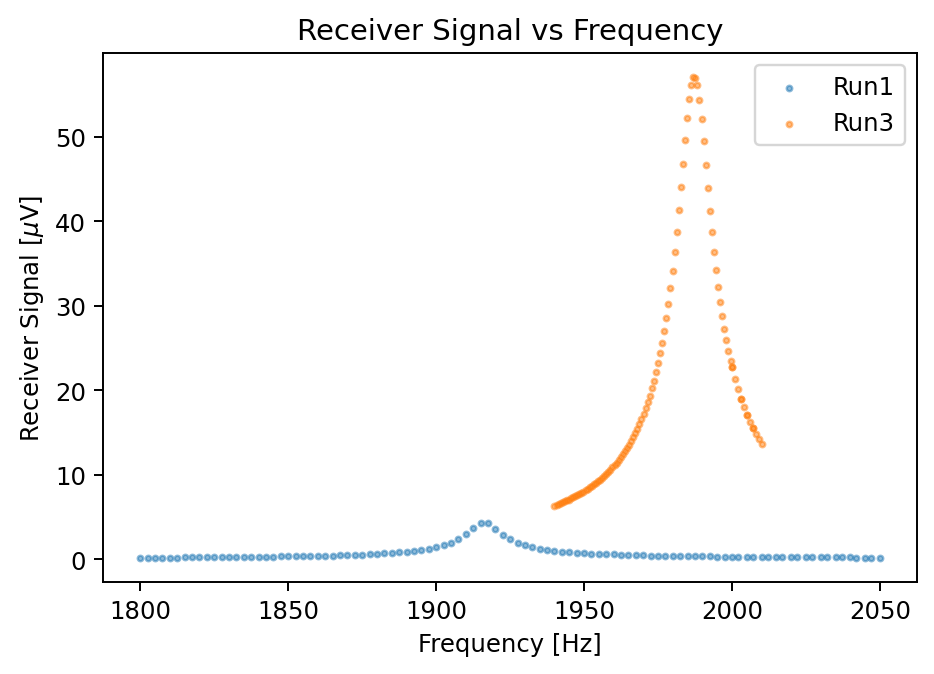

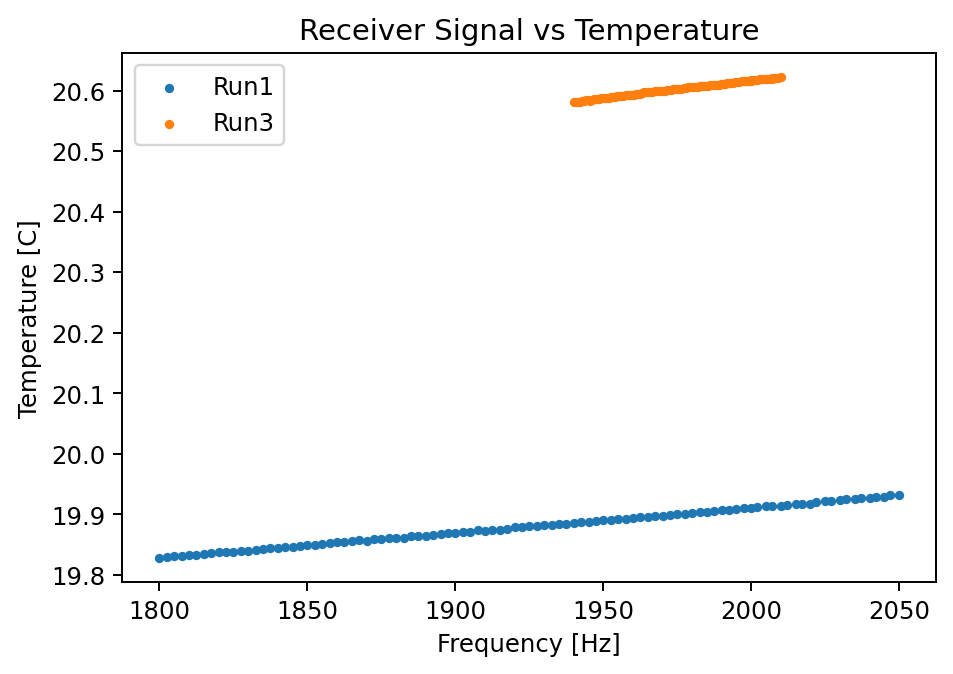

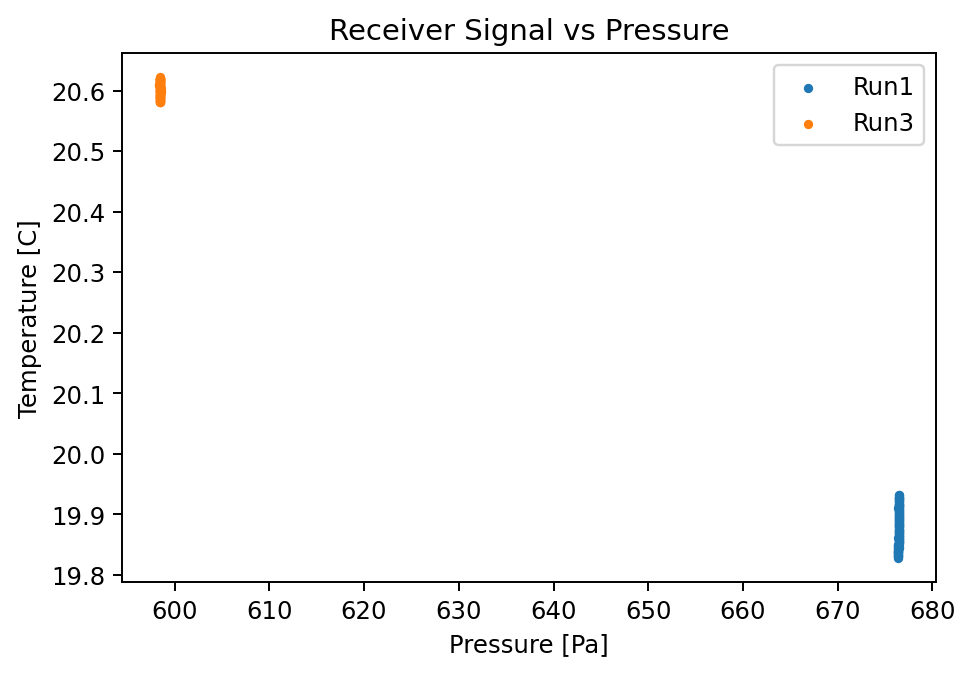

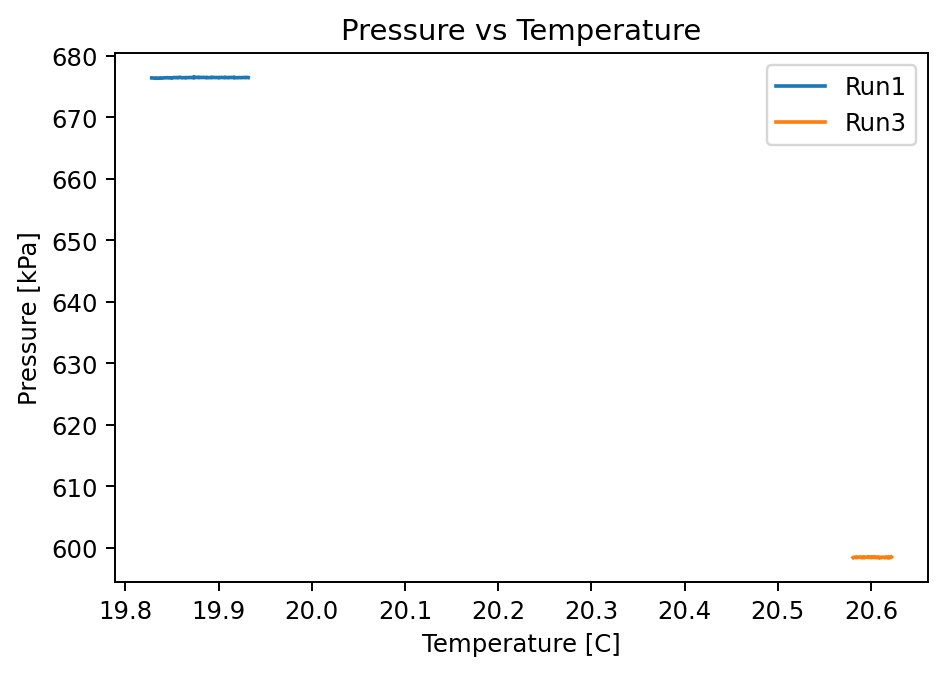

In [3]:
plt.figure(dpi=175)
plt.title("Receiver Signal vs Frequency")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Receiver Signal [$\mu$V]")


plt.scatter(raw_data1["frequency"], raw_data1["signal"], s=5, alpha=0.5, label="Run1")
plt.scatter(raw_data2["frequency"], raw_data2["signal"], s=5, alpha=0.5, label="Run3")
plt.legend()
#plt.ylim(50,60)
#plt.legend()

#plt.savefig("Plots/Nitrogen_Signal_Freq.pdf")
plt.show()



plt.figure(dpi=175)
plt.title("Receiver Signal vs Temperature")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Temperature [C]")

plt.scatter(raw_data1["frequency"], raw_data1["temp"], s=8, label="Run1")
plt.scatter(raw_data2["frequency"], raw_data2["temp"], s=8, label="Run3")
plt.legend()
plt.show()

plt.figure(dpi=175)
plt.title("Receiver Signal vs Pressure")
plt.xlabel("Pressure [Pa]")
plt.ylabel("Temperature [C]")

plt.scatter(raw_data1["pressure"], raw_data1["temp"], s=8, label="Run1")
plt.scatter(raw_data2["pressure"], raw_data2["temp"], s=8, label="Run3")
plt.legend()
plt.show()

plt.figure(dpi=175)
plt.title("Pressure vs Temperature")
plt.ylabel("Pressure [kPa]")
plt.xlabel("Temperature [C]")

plt.plot(raw_data1["temp"], raw_data1["pressure"], label="Run1")
plt.plot(raw_data2["temp"], raw_data2["pressure"], label="Run3")
plt.legend()

plt.show()

### Resonance Fitting

In [4]:
np.std(raw_data2["temp"])

0.011903978223671384

[  48.84401557 1916.16959123   11.16392008]
[0.09708141 0.01733477 0.0357238 ]
[0.19875804 0.00090466 0.31999336]


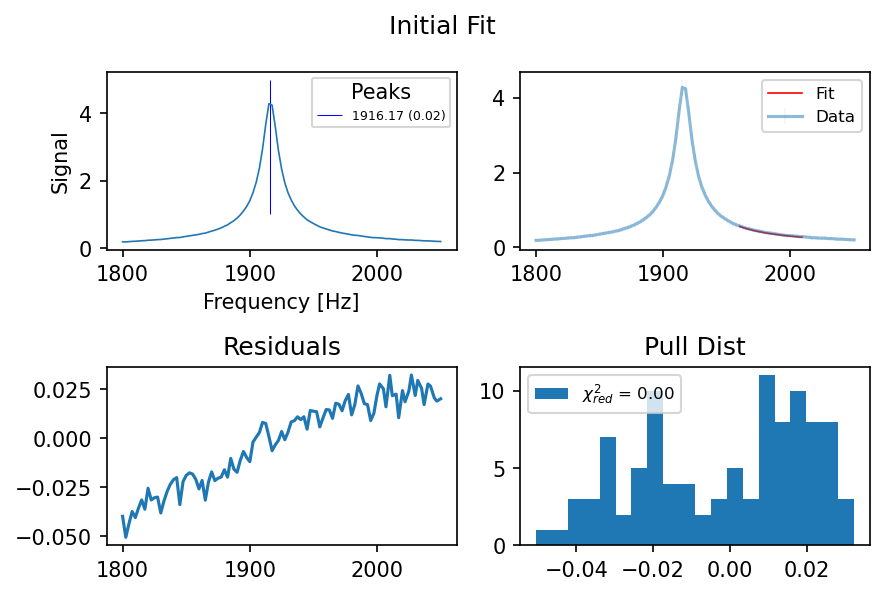

CPU times: user 429 ms, sys: 62.6 ms, total: 492 ms
Wall time: 503 ms


In [5]:
%%time
def gauss(x,mu=0,sigma=1):
    return np.exp(-((mu-x)**2/(2*(sigma)**2)))

def single_Gauss(x, A,mu1,sig1, d): 
    return A*gauss(x,mu1,sig1) + d

def resonance(x, A,Q,f0, d):
    g=x/f0
    s=(1-g**2)
    D=Q**2*s**2+g**2
    y=A*Q/D + d
    return y

def Resonance_New(x, A,f0,g):
    return ((A*x)/np.sqrt((x**2 - f0**2)**2 + ((g**2)*(x**2))))

func = Resonance_New

##Get Hist
plt.figure(dpi=150)
plt.suptitle(f"Initial Fit")
plt.subplot(2, 2, 1)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Signal")

keeps = raw_data1["frequency"] > -1

frequency = raw_data1["frequency"][keeps]
signal = raw_data1["signal"][keeps]

plt.plot(frequency, signal, lw=.8)

errors = signal.values**0.5

#pars, cov = scipy.optimize.curve_fit(single_Gauss, frequency.values, signal.values, #maxfev=3*10**5, sigma=errors,
#                                     p0=[3,460,20, 1],
#                                     bounds=([0.01,380,1, 0],
#                                             [5,520,200, 1.5]))
pars, cov = scipy.optimize.curve_fit(func, frequency.values, signal.values, maxfev=3*10**5, #sigma=errors,
                                     p0=[3,20,1900],#, 1], #[3,460,20, 1],
                                     #bounds=([0.01,380,1, 0],
                                     #        [5,520,200, 1.5]))
                                    )
#Mean Lines
plt.vlines(pars[-2],1,5, label=f"{pars[-2]:.2f} ({np.sqrt(cov.diagonal())[-2]:.2f})", color="blue", lw=0.5)

plt.legend(title="Peaks", prop={"size":6})

#Plot Fit
plt.subplot(2, 2, 2)
x = np.arange(1960,2010,1)
#shows = (np.arange(0,len(wavelength),1)%10 == 0)

plt.errorbar(frequency.values, 
             signal.values, yerr=errors/10, ms=.2, elinewidth=.1, alpha=0.5, label="Data")
plt.plot(x, func(x, *pars), color="red", lw=.8, label="Fit")
plt.legend(prop={"size":8})
#plt.xscale("log")
#plt.set_xticks(np.arange(300,901,50), minor=1)

print(pars)
print(np.sqrt(cov.diagonal()))
print(np.sqrt(cov.diagonal())/np.abs(pars)*100)

#Residuals
residuals = (signal.values-func(frequency.values, *pars))/errors
plt.subplot(2, 2, 3)
plt.title("Residuals")
plt.plot(frequency.values, residuals)#, s=1)

#Pull Dist
plt.subplot(2, 2, 4)
plt.title("Pull Dist")
red = "{red}"
plt.hist(residuals, 20, label=f"$\chi_{red}^2$ = {np.sum(residuals**2)/len(residuals):.2f}")
plt.legend(prop={"size":8})

plt.tight_layout()
#plt.savefig(f"Plots/GasTrio_Fit_Run3.pdf")
plt.show()

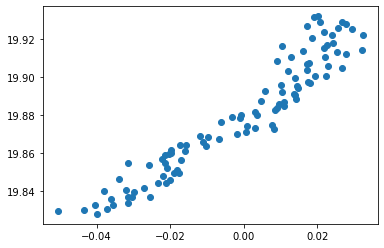

In [6]:
plt.scatter(residuals,raw_data1["temp"])

In [7]:
%%time
n = 10**6

K = np.random.normal(1.400**-1, 0.001, n)
m = (((14.0067*2)*931.49*10**6))
T = np.random.normal(np.mean(raw_data2["temp"]), np.sqrt(np.std(raw_data2["temp"])**2 + 0.1**2), n) + 273.15

L = np.random.normal(87.5, 0.5, n) *10**-3
f0 = np.random.normal(1987.29, .01, n)
v2 = (2*L*f0)**2
c2 = 299792458**2

result = K*(m/T)*(v2/c2)

print(f"{np.mean(result):.2e} +/- {np.std(result):.1e}")

print((np.mean(result)-8.617333262*10**-5)/np.std(result))


8.54e-05 +/- 9.8e-07
-0.7956616221516931
CPU times: user 180 ms, sys: 14.7 ms, total: 194 ms
Wall time: 195 ms


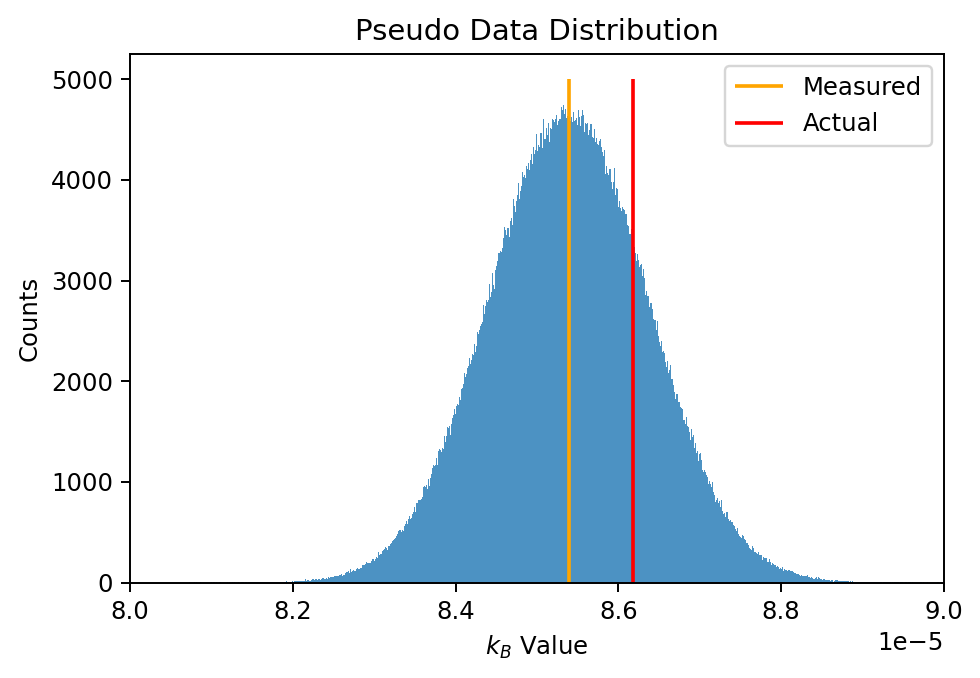

In [8]:
plt.figure(dpi=175)
plt.title("Pseudo Data Distribution")
plt.xlabel("$k_B$ Value")
plt.ylabel("Counts")
plt.hist(result, bins=800, alpha=0.8, )
plt.vlines(np.mean(result), 0, 5000, color="orange", label="Measured")
plt.vlines(8.617333262*10**-5, 0, 5000, color="red", label="Actual")
plt.legend()
plt.xlim(8*10**-5,9.0*10**-5)

plt.savefig(f"Plots/PseudoData_Distribution.pdf")
plt.show()

In [9]:
(1.400**-1)*(((14*2)*931.5*10**6)/(20+273))*((2*(87.5*10**-3)*1987)**2)*(3*10**8)**-2


8.542294830844712e-05

In [10]:
340*(1+1/0.518)

996.3706563706563

## Binary Gas

In [11]:
n = 10**6

kB = 1.380649*10**-23 #J/K #np.random.normal(1.400**-1, 0.001, n) #in 
T = np.random.normal(np.mean(raw_data2["temp"]), np.sqrt(np.std(raw_data2["temp"])**2 + 0.1**2), n) + 273.15
A = 6.0221408*10**23 * 10**3 #kmol

L = np.random.normal(87.5, 0.5, n) * 10**-3
f0 = np.random.normal(1987.29, .01, n) 

RA = 1
RB = 1

xA = RA / (RA + RB)
cpA = 0.918 #O2 in [kJ/kg.K]
cpB = 1.039 #N2 in [kJ/kg.K]
cvA = 0.658 #O2 
cvB = 0.743 #N2
mA = 31.999 #O2
mB = 28.013 #N2

lhs = (2*L*f0)**2
rhs = ((xA*cpA + (1-xA)*cpB)/(xA*cvA + (1-xA)*cvA)) * ((A*kB*T)/(xA*mA + (1-xA)*mB))

calc_f0 = (((xA*cpA + (1-xA)*cpB)/(xA*cvA + (1-xA)*cvB)) * ((A*kB*T)/(xA*mA + (1-xA)*mB))/(2*L)**2)**0.5

#print(f" {np.mean(lhs):.4}\n {np.mean(rhs):.4}")
print(f"Calc f0: {np.mean(calc_f0):4.0f} +/- {np.std(calc_f0):4.0f} [Hz]")
print(f"Measured f0: {1916.53} +/- {.01} [Hz]")

Calc f0: 1927 +/-   11 [Hz]
Measured f0: 1916.53 +/- 0.01 [Hz]
